In [1]:
import glob
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.io import read_image, ImageReadMode
from torchvision.transforms.functional import to_pil_image
from torchmetrics.classification import BinaryF1Score, BinaryAveragePrecision
from tqdm.auto import tqdm
from model.fsg import FSG, gaussian_filter_2d

In [9]:
fsg = FSG.load_from_checkpoint("fsg_image_128_pytorch_from_tf1.ckpt", fast_sim_mode=True, loc_threshold=0.3)

Warning! Some keys are not loaded! Not loaded keys are:
['constrained_conv.one_middle']
Success! All necessary keys for module 'CompareNet' are loaded!


In [10]:
device = "cuda:0"

In [11]:
fsg = fsg.eval().to(device)

In [12]:
image_paths = sorted(glob.glob("example_images/splicing-??.png"))
gt_paths = sorted(glob.glob("example_images/splicing-??-gt.png"))
image_vs_gt_paths = list(zip(image_paths, gt_paths))

In [13]:
with torch.no_grad():
    imgs = []
    gts = []
    img_preds = []
    loc_preds = []
    f1, mAP = BinaryF1Score(), BinaryAveragePrecision()
    for image_path, gt_path in tqdm(image_vs_gt_paths):
        image = read_image(image_path, mode=ImageReadMode.RGB).float()
        gt = (1 - read_image(gt_path, mode=ImageReadMode.GRAY).float()[0] / 255)
        gt = gaussian_filter_2d(gt, 32) > 0.14
        img_pred, loc_pred = fsg(image.unsqueeze(0).to(device))
        img_pred, loc_pred = img_pred.cpu()[0], loc_pred.cpu()[0]
        f1.update(loc_pred, gt)
        mAP.update(loc_pred, gt)
        img_preds.append(img_pred)
        loc_preds.append(loc_pred)
        imgs.append(image)
        gts.append(gt)

  0%|          | 0/9 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
libpng warning: iCCP: known incorrect sRGB profile


In [14]:
f1.compute().item(), mAP.compute().item()

(0.8673990368843079, 0.7756929397583008)

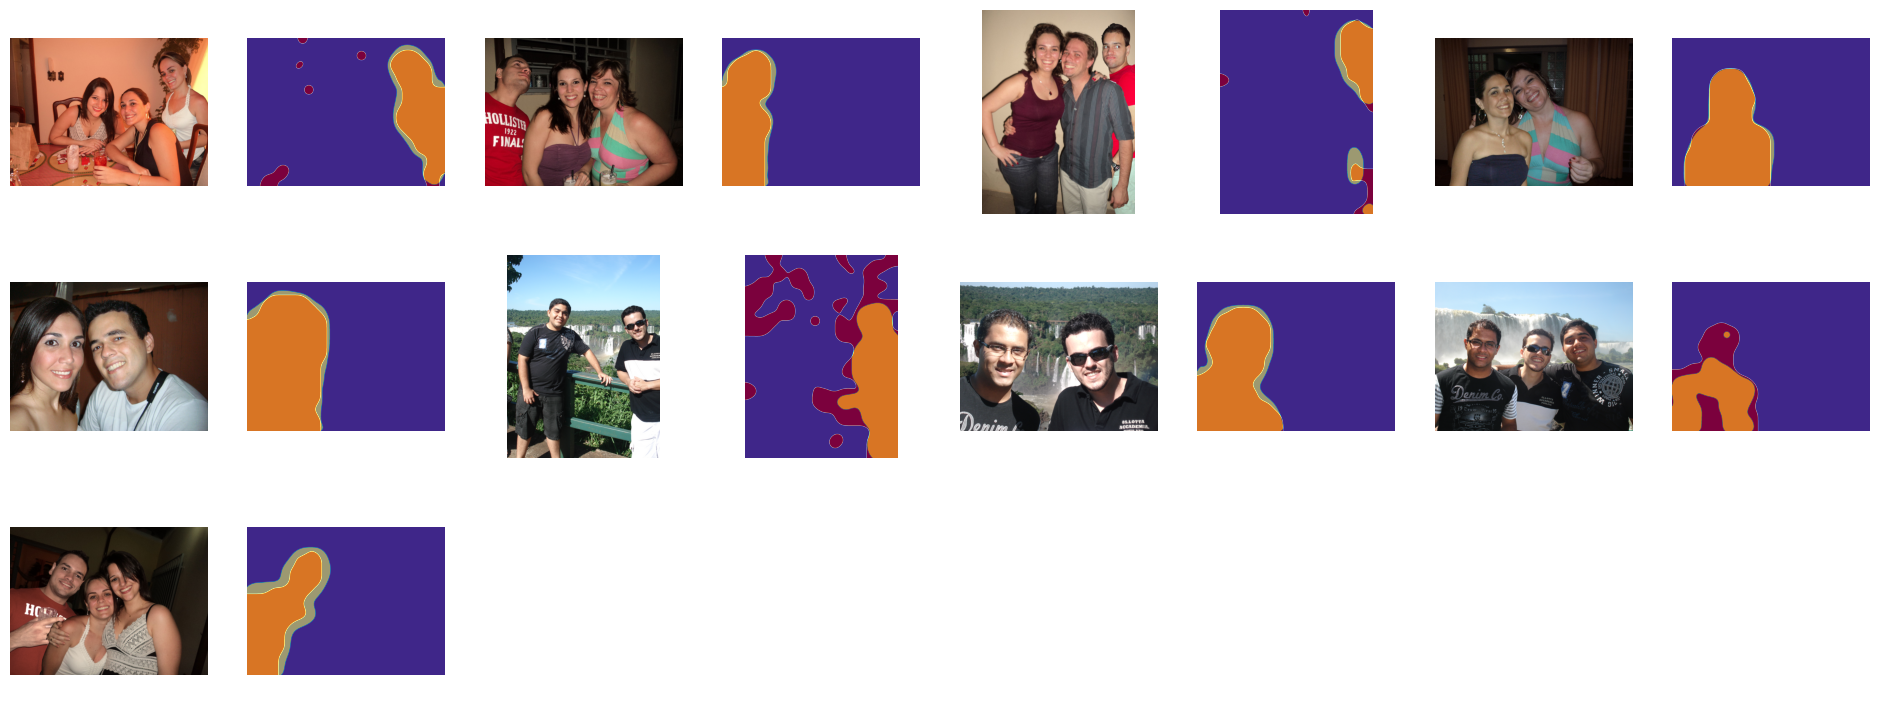

In [15]:
col = 4 * 2
row = -(-len(image_vs_gt_paths) // 4)
fig, axs = plt.subplots(row, col)
fig.set_size_inches(3 * col, 3 * row)
for i, (img, gt, img_pred, loc_pred) in enumerate(zip(imgs, gts, img_preds, loc_preds)):
    ax = axs[i // 4][(i % 4) * 2]
    ax.imshow(to_pil_image(img.byte()))
    ax = axs[i // 4][(i % 4) * 2 + 1]
    ax.imshow(to_pil_image(gt.float()))
    ax.imshow(loc_pred, alpha=0.5, cmap="coolwarm")

for ax in axs.flat:
    ax.axis("off")